In [ ]:
# !pip install tensorflow


In [1]:
import sys
from pathlib import Path

# Zum übergeordneten Ordner 'src' wechseln
current_path = Path().resolve()
src_path = current_path.parents[2]  # Zwei Stufen nach oben

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

src_path


WindowsPath('C:/Users/Nasiba/Documents/1 Master Data Science/Projektpraktikum/WebScience24')

In [2]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from collections import Counter
#nlp = spacy.load("en_core_web_sm")
from nltk import word_tokenize
pd.set_option('display.max_colwidth', None)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from vector_functions import vectorize_word2vec, vectorize_glove, vectorize_glove_no_avarage, vectorize_word2vec_no_average
import nltk

import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout
from tensorflow.keras.utils import to_categorical



#### Beladung der Daten

In [3]:

source_filepath_name = os.path.abspath(os.path.join(src_path, 'data/twitter_hate-speech/train_cleaned.csv'))

df_cleaned = pd.read_csv(source_filepath_name, encoding='utf-8', index_col=0)
df_cleaned.head(1)

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
id,,,,,,
8886,0,@user #cinemaaawards final rehearsals!! gearing up for the evening!! #butterflies #stage ! hope u all like it,cinema award final rehearsal gear evening butterfly stage hope like,1,"['#cinemaaawards', '#butterflies', '#stage']",NaN


### Vektorisierung

#### GloVe 

In [12]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.twitter.27B.100d.txt'))


X_train_vectors_wht_av, X_test_vectors_wht_av, y_train_wht_av, y_test_wht_av, glove_embeddings_wht_av = vectorize_glove_no_avarage(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)


X_train_vectors_wht_av.size



c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:286: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


70620000

### Reshaping für LSTM

In [15]:
print(X_train_vectors_wht_av.shape)
print(X_test_vectors_wht_av.shape)


(14124, 50, 100)
(6054, 50, 100)
(14124, 100)
(6054, 100)


### Modell aufbauen 

#### Vektoren ohne Durchschnitt

##### Die Modelleingaben überprüfen

In [26]:
samples, max_seq_len, vector_size = X_train_vectors_wht_av.shape
num_classes = len(np.unique(y_train_wht_av))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_vectors_wht_av.shape)
print(len(np.unique(y_test_wht_av)))

14124
50
100
2
(6054, 50, 100)
2


#### One-Hot-Encoding der Labels

In [30]:

y_train_onehot = to_categorical(y_train_wht_av, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_wht_av, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


##### Modellinitialisierung

In [31]:

# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='softmax'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#####  Modell trainieren

In [32]:

history = model.fit(
    X_train_vectors_wht_av, y_train_onehot,
    validation_data=(X_test_vectors_wht_av, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.9277 - loss: 0.2676 - val_accuracy: 0.9395 - val_loss: 0.1430
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9362 - loss: 0.1652 - val_accuracy: 0.9511 - val_loss: 0.1388
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9449 - loss: 0.1511 - val_accuracy: 0.9556 - val_loss: 0.1294
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9499 - loss: 0.1395 - val_accuracy: 0.9595 - val_loss: 0.1213
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9526 - loss: 0.1305 - val_accuracy: 0.9569 - val_loss: 0.1209
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9566 - loss: 0.1202 - val_accuracy: 0.9574 - val_loss: 0.1278
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9617 - loss: 0.1140 - val_accuracy: 0.9407 - val_loss: 0.1384
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9642 - loss: 0.1030 - 

### Modell bewerten

In [41]:

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_vectors_wht_av, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9478 - loss: 0.1297
Test Loss: 0.12405049800872803
Test Accuracy: 0.9519326090812683


### Vorhersagen treffen

In [43]:
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors_wht_av)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))




190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step
Predicted classes: [0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]
Actual classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [37]:


# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.98      0.97      0.97      5687
     Class 1       0.59      0.69      0.63       367

    accuracy                           0.95      6054
   macro avg       0.78      0.83      0.80      6054
weighted avg       0.96      0.95      0.95      6054



[[5510  177]
 [ 114  253]]


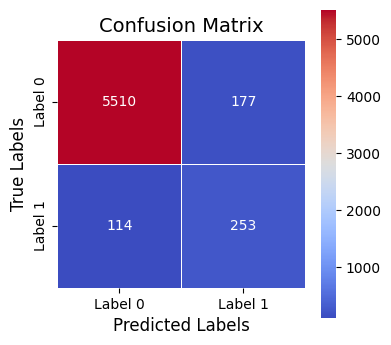

In [48]:
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Vektor word2w

In [4]:

X_train_w2v, X_test_w2v, y_train_wv, y_test_vw, w2v_model = vectorize_word2vec_no_average(df=df_cleaned, text_column ="tweet_cleaned", label_column="label")

print("Erste Trainingsvektoren:")
print(X_train_w2v[:2])

c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


Erste Trainingsvektoren:
[[[-0.27366632  0.59377503  0.24173051 ... -0.71544862  0.43441492
    0.148491  ]
  [-0.20591068  0.55211949  0.13490196 ... -0.47483411  0.30856198
    0.0022539 ]
  [-0.0877643   0.16565731  0.04981716 ... -0.16643453  0.12053686
   -0.01899492]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[-0.37556157  0.58749545  0.17904741 ... -0.71730393  0.54872096
   -0.26690394]
  [-0.08293848  0.2228906   0.08971734 ... -0.26991111  0.16464275
   -0.00287571]
  [-0.20412913  0.47566864  0.24698061 ... -0.5018931   0.48744324
   -0.15143053]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]]


In [5]:
print(X_train_w2v.shape)
print(X_test_w2v.shape)


(14124, 50, 100)
(6054, 50, 100)


In [6]:

samples,max_seq_len, vector_size = X_train_w2v.shape
num_classes = len(np.unique(y_train_wv))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_w2v.shape)
print(len(np.unique(y_test_vw)))

14124
50
100
2
(6054, 50, 100)
2


In [7]:

y_train_onehot = to_categorical(y_train_wv, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_vw, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [8]:

# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='softmax'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:

history = model.fit(
    X_train_w2v, y_train_onehot,
    validation_data=(X_test_w2v, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)

Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.9250 - loss: 0.3023 - val_accuracy: 0.9394 - val_loss: 0.2283
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9325 - loss: 0.2496 - val_accuracy: 0.9394 - val_loss: 0.2126
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.9289 - loss: 0.2349 - val_accuracy: 0.9374 - val_loss: 0.2180
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.9287 - loss: 0.2289 - val_accuracy: 0.9394 - val_loss: 0.1920
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9353 - loss: 0.2092 - val_accuracy: 0.9394 - val_loss: 0.1911
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9319 - loss: 0.2146 - val_accuracy: 0.9389 - val_loss: 0.1860
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9265 - loss: 0.2213 - val_accuracy: 0.9394 - val_loss: 0.1814
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.9314 - loss: 0.2011 - 

In [10]:

# Testgenauigkeit
test_loss, test_accuracy = model.evaluate(X_test_w2v, y_test_onehot)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9411 - loss: 0.1780
Test Loss: 0.17729629576206207
Test Accuracy: 0.939213752746582


In [11]:
# Vorhersagen auf Testdaten
predictions = model.predict(X_test_w2v)
predicted_classes = np.argmax(predictions, axis=1)

# Beispiel: Erste 5 Vorhersagen anzeigen
print("Predicted classes:", predicted_classes[:50])
print("Actual classes:", np.argmax(y_test_onehot[:50], axis=1))




190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Predicted classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0]


In [12]:


# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97      5687
     Class 1       0.44      0.01      0.02       367

    accuracy                           0.94      6054
   macro avg       0.69      0.51      0.49      6054
weighted avg       0.91      0.94      0.91      6054



[[5682    5]
 [ 363    4]]


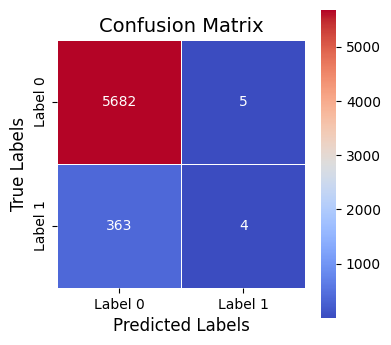

In [13]:
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Modeltraining mit anderen Parametern

(Aktivierungsfunktion in der Dense-Schicht zu sigmoid ändern, da diese für Binärklassifikation besser geeignet sein soll)

In [15]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.twitter.27B.100d.txt'))


X_train_vectors_wht_av, X_test_vectors_wht_av, y_train_wht_av, y_test_wht_av, glove_embeddings_wht_av = vectorize_glove_no_avarage(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)


X_train_vectors_wht_av.size



c:\Users\Nasiba\Documents\1 Master Data Science\Projektpraktikum\WebScience24\src\3. Deep Learning Approach\nasiba\vector_functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[text_column] = df[text_column].astype(str)


70620000

In [16]:
print(X_train_vectors_wht_av.shape)
print(X_test_vectors_wht_av.shape)
samples, max_seq_len, vector_size = X_train_vectors_wht_av.shape
num_classes = len(np.unique(y_train_wht_av))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_vectors_wht_av.shape)
print(len(np.unique(y_test_wht_av)))

y_train_onehot = to_categorical(y_train_wht_av, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_wht_av, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)


# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='sigmoid'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



history = model.fit(
    X_train_vectors_wht_av, y_train_onehot,
    validation_data=(X_test_vectors_wht_av, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)


history = model.fit(
    X_train_vectors_wht_av, y_train_onehot,
    validation_data=(X_test_vectors_wht_av, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)





(14124, 50, 100)
(6054, 50, 100)
14124
50
100
2
(6054, 50, 100)
2
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.9169 - loss: 0.3010 - val_accuracy: 0.9394 - val_loss: 0.2221
Epoch 2/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - accuracy: 0.9313 - loss: 0.2467 - val_accuracy: 0.9394 - val_loss: 0.2040
Epoch 3/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.9297 - loss: 0.2542 - val_accuracy: 0.9394 - val_loss: 0.2275
Epoch 4/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9320 - loss: 0.2499 - val_accuracy: 0.9356 - val_loss: 0.2184
Epoch 5/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.9304 - loss: 0.2511 - val_accuracy: 0.9394 - val_loss: 0.2290
Epoch 6/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9369 - loss: 0.2383 - val_accuracy: 0.9394 - val_loss: 0.2288
Epoch 7/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.9353 - loss: 0.2423 - val_accuracy: 0.9394 - val_loss: 0.2296
Epoch 8/10
442/442 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.9303 - loss: 0.2557 - 

In [19]:


# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors_wht_av)
predicted_classes = np.argmax(predictions, axis=1)

# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)



190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Classification Report:
               precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97      5687
     Class 1       0.00      0.00      0.00       367

    accuracy                           0.94      6054
   macro avg       0.47      0.50      0.48      6054
weighted avg       0.88      0.94      0.91      6054



C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Nasiba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

[[5687    0]
 [ 367    0]]


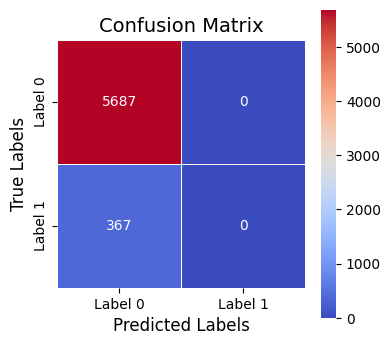

In [20]:
cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

#### Modeltraining mit anderen Parametern

(vector_size, max_seq_len geändert)

In [ ]:


twitter_glove_path = os.path.abspath(os.path.join(src_path, 'src/3. Deep Learning Approach/nasiba/glove.twitter.27B.100d.txt'))


X_train_vectors_wht_av, X_test_vectors_wht_av, y_train_wht_av, y_test_wht_av, glove_embeddings_wht_av = vectorize_glove_no_avarage(df=df_cleaned, text_column ="tweet_cleaned", label_column="label", glove_path=twitter_glove_path)


X_train_vectors_wht_av.size

print(X_train_vectors_wht_av.shape)
print(X_test_vectors_wht_av.shape)
samples, max_seq_len, vector_size = X_train_vectors_wht_av.shape
num_classes = len(np.unique(y_train_wht_av))
print(samples)
print(max_seq_len)
print(vector_size)
print(num_classes)
print(X_test_vectors_wht_av.shape)
print(len(np.unique(y_test_wht_av)))

y_train_onehot = to_categorical(y_train_wht_av, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_wht_av, num_classes=num_classes)
print(y_train_onehot)
print(y_test_onehot)


# Modellinitialisierung
model = Sequential()

# LSTM-Schicht
model.add(LSTM(units=128, input_shape=(max_seq_len, vector_size), return_sequences=False))

# Optional: Dropout zur Vermeidung von Overfitting
model.add(Dropout(0.5))

# Dense-Schicht für die Ausgabe
model.add(Dense(units=num_classes, activation='sigmoid'))

# Kompilieren des Modells
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



history = model.fit(
    X_train_vectors_wht_av, y_train_onehot,
    validation_data=(X_test_vectors_wht_av, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)


history = model.fit(
    X_train_vectors_wht_av, y_train_onehot,
    validation_data=(X_test_vectors_wht_av, y_test_onehot),
    epochs=10,
    batch_size=32,
    verbose=1
)



# Vorhersagen auf Testdaten
predictions = model.predict(X_test_vectors_wht_av)
predicted_classes = np.argmax(predictions, axis=1)

# Klassifikationsbericht erstellen
report = classification_report(np.argmax(y_test_onehot, axis=1), predicted_classes, target_names=["Class 0", "Class 1"])
print("Classification Report:\n", report)

cm = confusion_matrix(np.argmax(y_test_onehot, axis=1), predicted_classes)
print(cm)
# Verwirrungsmatrix visualisieren
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, square=True,
            xticklabels=["Label 0", "Label 1"], yticklabels=["Label 0", "Label 1"])
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()



